In [ ]:
import numpy as np

def run_graph_coloring_dsb(adj_matrix, num_colors, steps=10000, a0=1.0, c0=1.0, dt=0.01):
    """
    Run a Dynamic Simulation-Based (DSB) algorithm for solving graph coloring problems.
    
    Args:
        adj_matrix: Adjacency matrix of the graph (1 if vertices are connected, 0 otherwise)
        num_colors: Maximum number of colors to use
        steps: Number of simulation steps
        a0: System parameter (constant) controlling the momentum
        c0: Coupling strength for graph coloring constraints
        dt: Time step size
    
    Returns:
        color_assignment: The final color assignment (1 to num_colors) for each vertex
        violation_count: Number of edge violations in the final solution
        x_history: History of position values during simulation
    """
    # Get problem size
    N = adj_matrix.shape[0]  # Number of vertices
    K = num_colors  # Number of colors
    
    # Initialize positions and momenta
    # Instead of N binary variables, we now have N×K variables (one for each vertex-color pair)
    x = np.random.uniform(-0.1, 0.1, (N, K))  # Position variables
    y = np.zeros((N, K))                      # Momentum variables
    
    # Initialize history arrays
    x_history = np.zeros((steps + 1, N, K))
    x_history[0] = x.copy()
    
    # Define a(t) function - linear increase from 0 to a0
    def a_t_func(t):
        return min(a0 * t / (0.2 * steps * dt), a0)
    
    # Main simulation loop
    for step in range(1, steps + 1):
        t = step * dt
        a_t = a_t_func(t)
        
        # Get current approximate binary state using sigmoid
        x_prob = (x + 1)/2  # Values between 0 and 1
        
        # Calculate the gradient of the energy function
        gradient = np.zeros((N, K))
        
        # 1. Graph coloring constraint: adjacent vertices should have different colors
        for i in range(N):
            for j in range(N):
                if adj_matrix[i, j] == 1:  # If vertices i and j are adjacent
                    for c in range(K):
                        # If j has color c, push i away from color c
                        gradient[i, c] += c0 * x_prob[j, c]
        
        # 2. One-hot encoding constraint: each vertex should have exactly one color
        constraint_weight = 2.0 * c0  # Weight for one-hot encoding constraint
        for i in range(N):
            color_sum = np.sum(x_prob[i])
            for c in range(K):
                # Penalize if sum != 1
                gradient[i, c] += constraint_weight * (color_sum - 1) * x_prob[i, c]
        
        # First part of symplectic Euler: update momenta
        # ẏ = -[a0 - a(t)]x - gradient
        y -= dt * ((a0 - a_t) * x + gradient)
        
        # Second part: update positions
        # ẋ = a0 * y
        x += dt * a0 * y
        
        # Apply inelastic walls to help converge to binary solutions
        for i in range(N):
            # Find the maximum value for this vertex
            max_idx = np.argmax(x[i])
            max_val = x[i, max_idx]
            
            # If max is above threshold, make the solution more "binary"
            if max_val > 3.0:
                # Reset all components
                y[i] = np.zeros(K)
                x[i] = np.ones(K) * -2.0  # All start negative
                x[i, max_idx] = 2.0  # Except the max one
        
        # Store current positions
        x_history[step] = x.copy()
    
    # Get final color assignment
    # For each vertex, select the color with the highest value
    color_assignment = np.argmax(x, axis=1) + 1  # +1 to make colors 1-indexed
    
    # Count violations (adjacent vertices with the same color)
    violation_count = 0
    for i in range(N):
        for j in range(i+1, N):
            if adj_matrix[i, j] == 1 and color_assignment[i] == color_assignment[j]:
                violation_count += 1
    
    return color_assignment, violation_count, x_history

# Example usage
def example_graph_coloring(adj_matrix, num_colors):
    """
    Example of using the DSB algorithm to solve a graph coloring problem.
    """

    color_assignment, violations, _ = run_graph_coloring_dsb(
        adj_matrix, num_colors, steps=2000, a0=1.0, c0=2.0, dt=0.01
    )
    
    print(f"Color assignment: {color_assignment}")
    print(f"Number of violations: {violations}")
    if violations == 0:
        print("Valid coloring found!")
    else:
        print("No valid coloring found with the given parameters.")
    
    return color_assignment, violations


adj_matrix = np.array([[0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 0]])
num_colors = 7

example_graph_coloring(adj_matrix, num_colors)

# Experiment section

#####################################################
iteration 1 begins
max value of x 0.09974791492445742, min value of x -0.09800849519217766
max value of x_prob 0.09974791492445742, min value of x_prob -0.09800849519217766
max value of y 0.00409605858713386, min value of y -0.003832366336207525
###################### capping ###############################
max value of x after cap 0.09974791492445742, min value of x after cap -0.09800849519217766
max value of x_prob 0.09974791492445742, min value of x_prob -0.09800849519217766
max value of y after cap  0.00409605858713386, min value of y after cap  -0.003832366336207525
iteration 1 ends
#####################################################
#####################################################
iteration 2 begins
max value of x 0.09967385592344469, min value of x -0.09793049546315846
max value of x_prob 0.09967385592344469, min value of x_prob -0.09793049546315846
max value of y 0.008187827081069028, min value of y -0.007660712510821

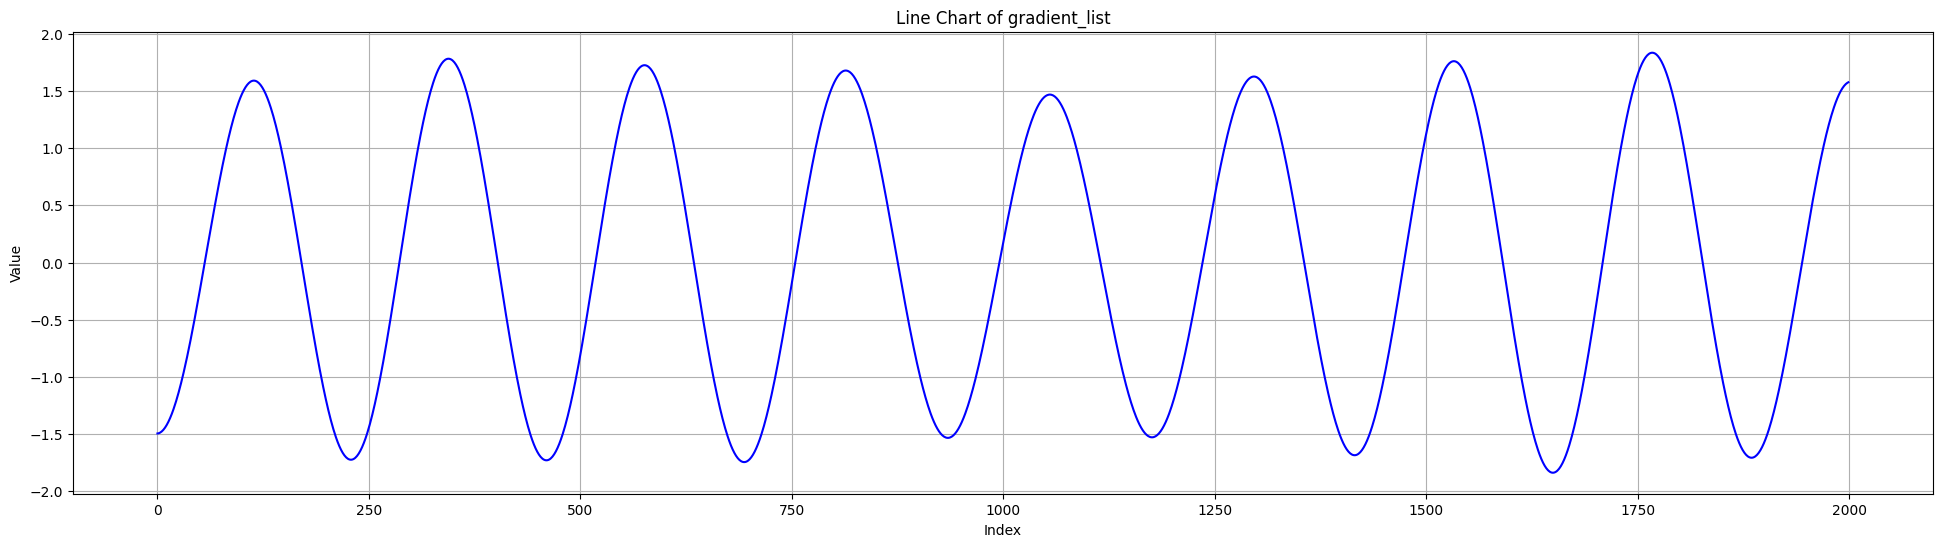

1.5766670521632768


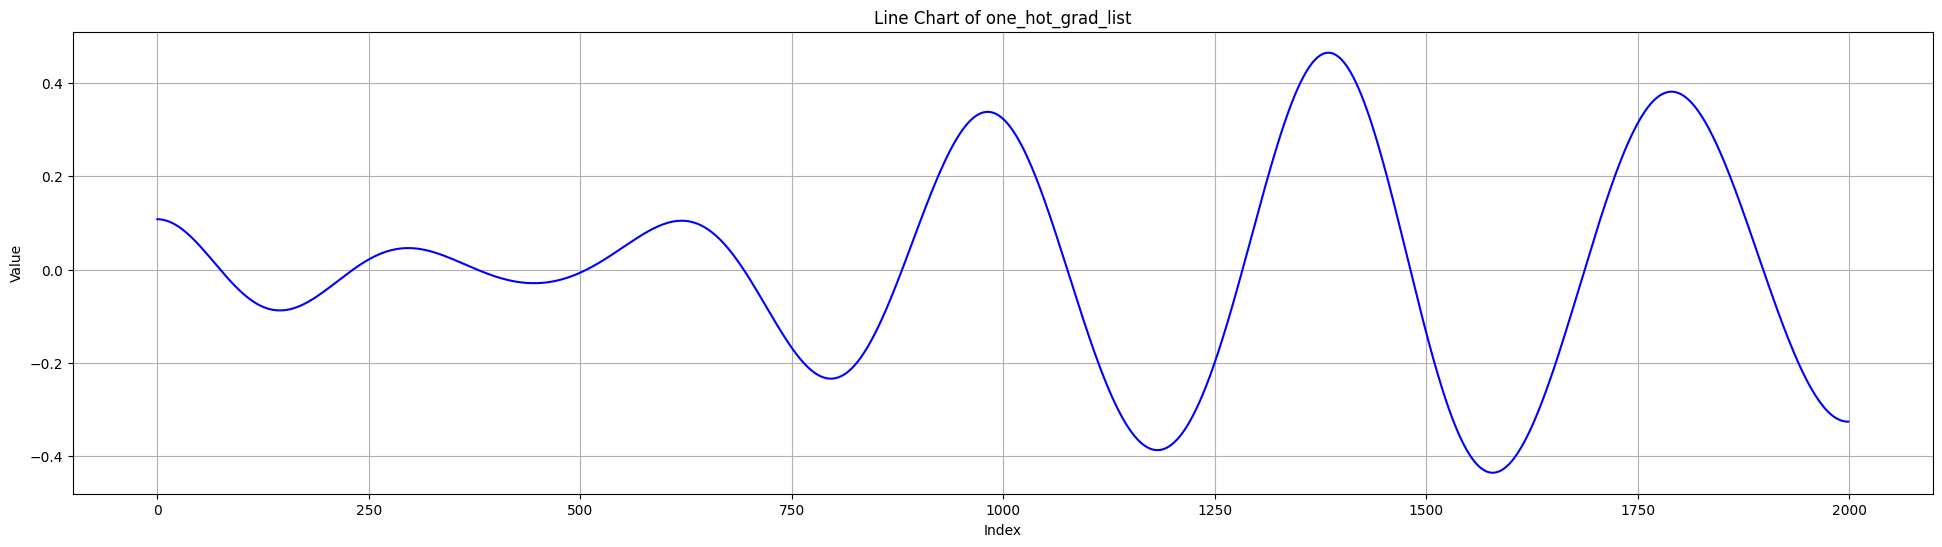

-0.3256810837940376


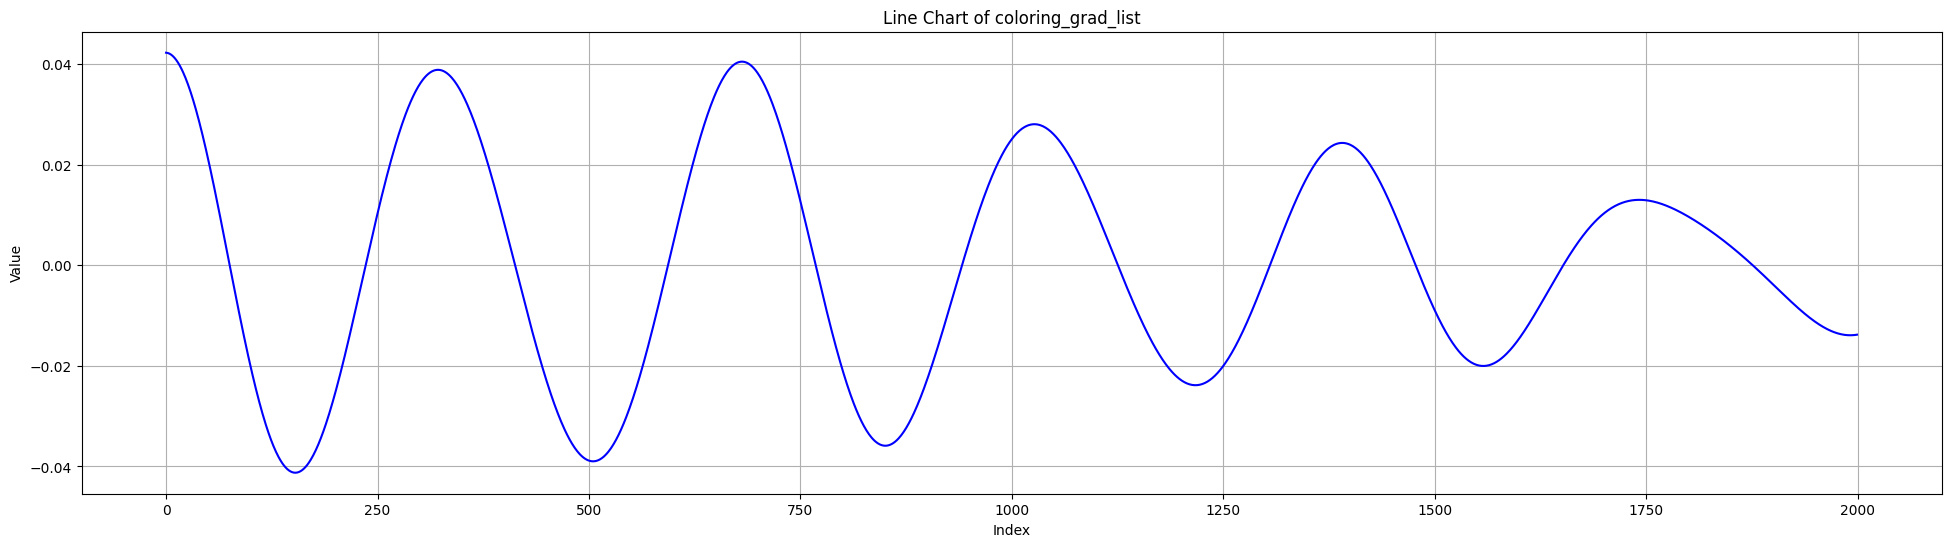

-0.013800369336914893


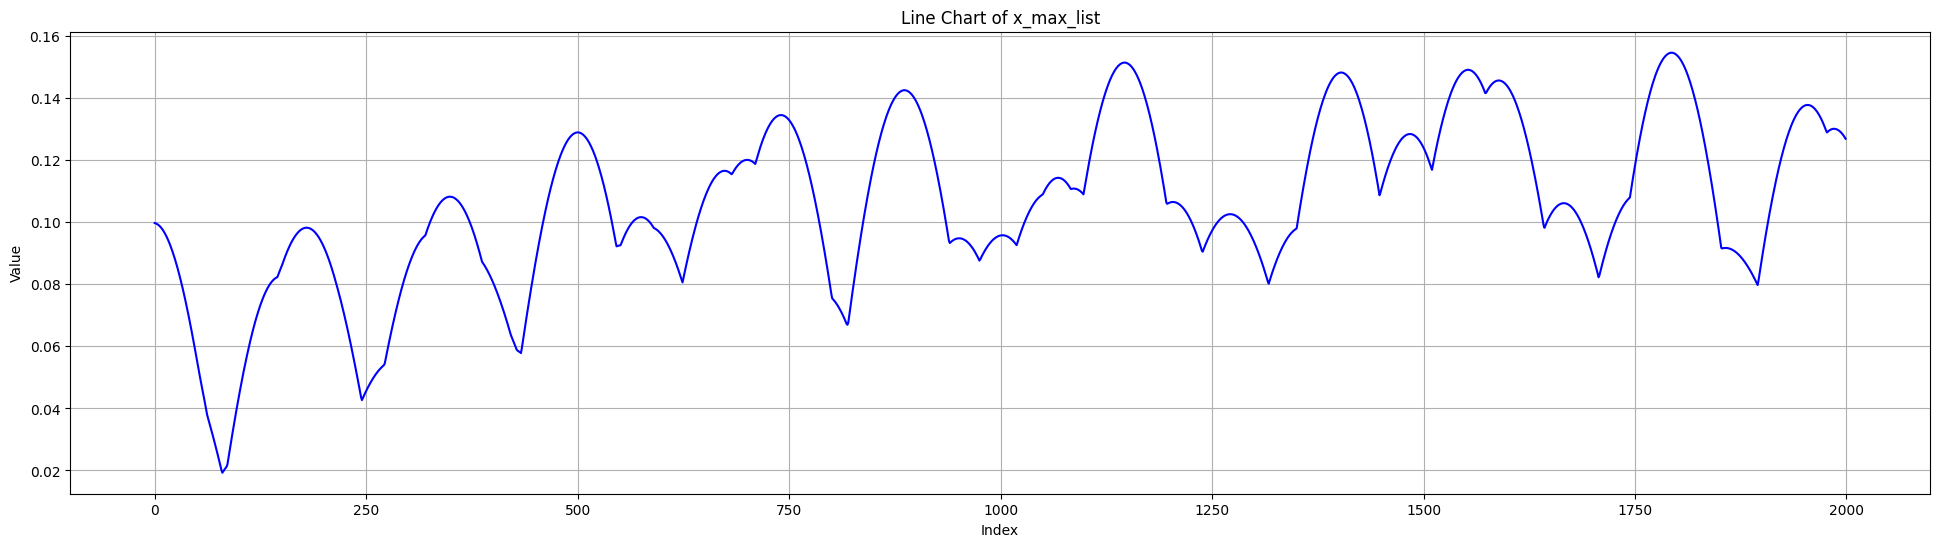

-0.013800369336914893


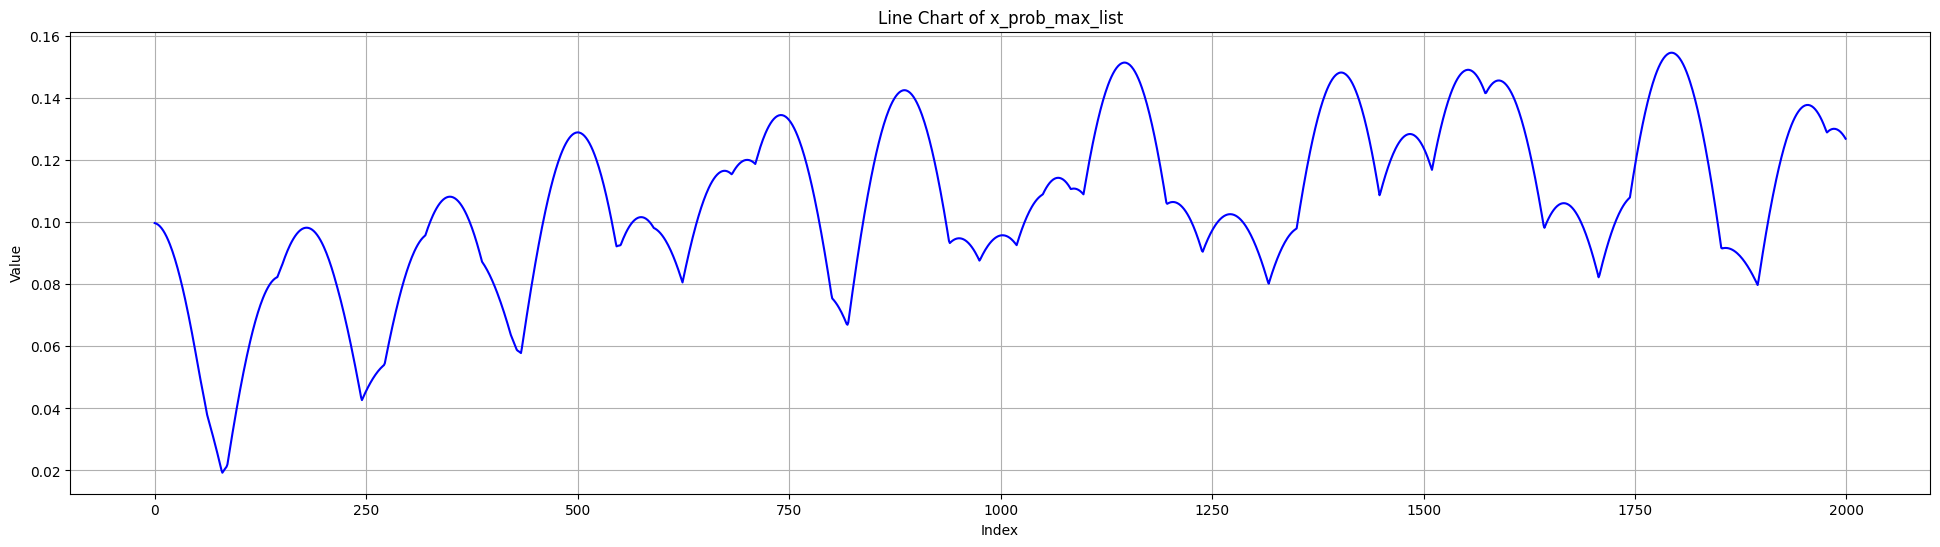

-0.013800369336914893


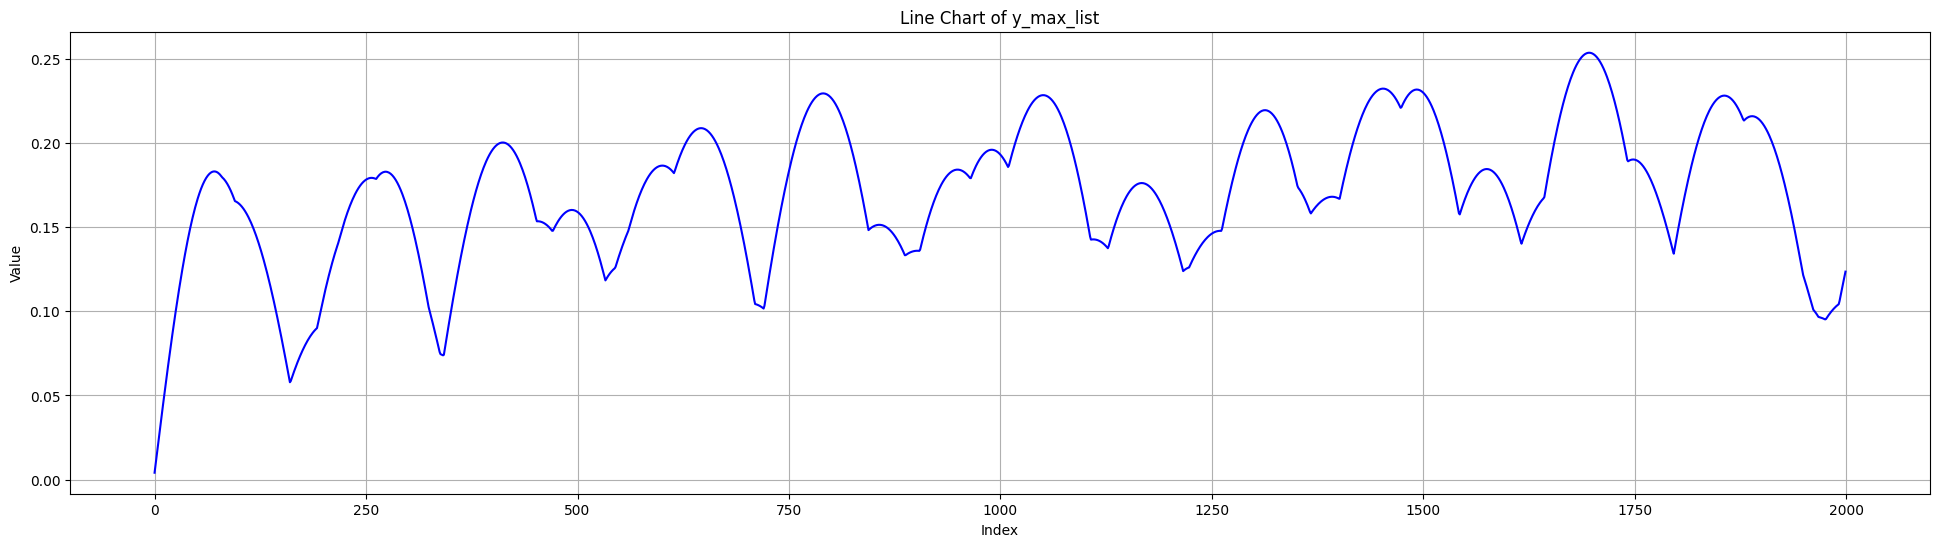

-0.013800369336914893


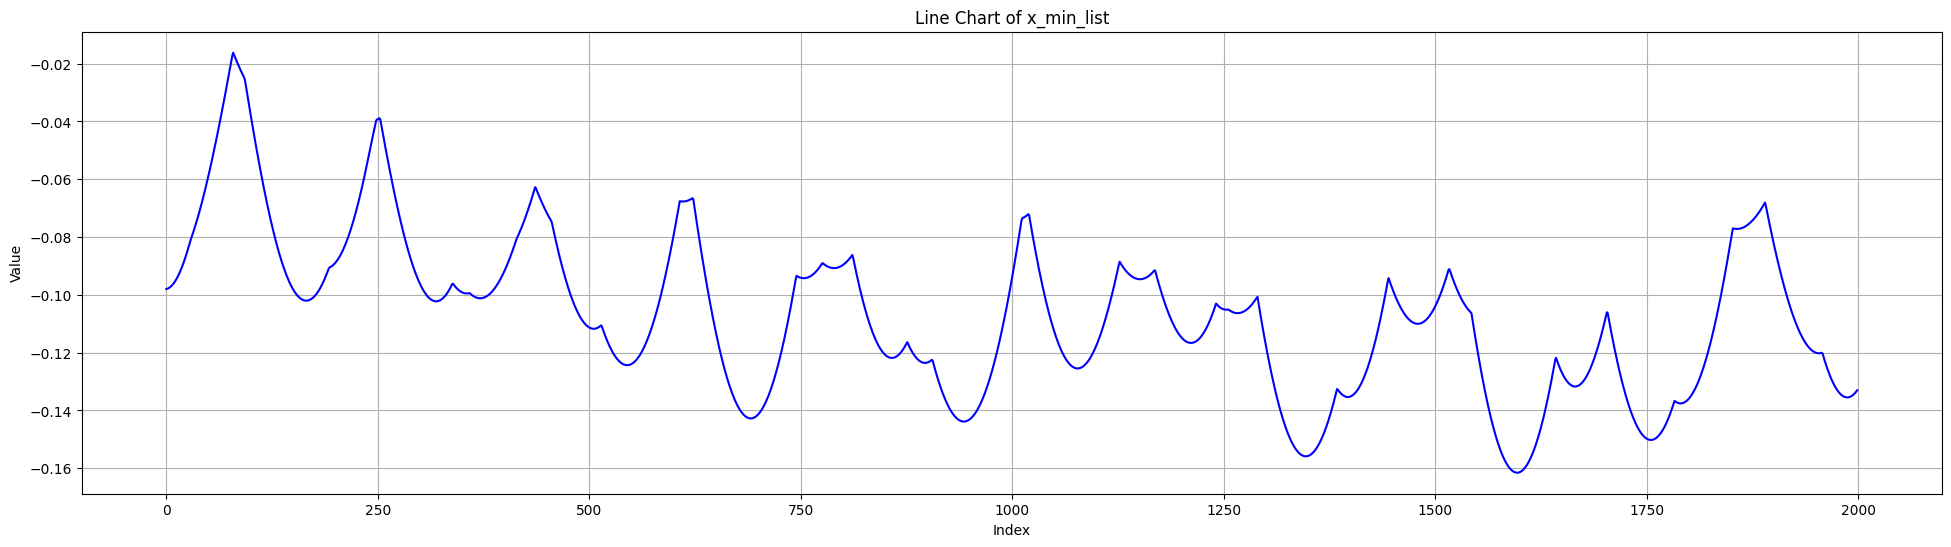

-0.013800369336914893


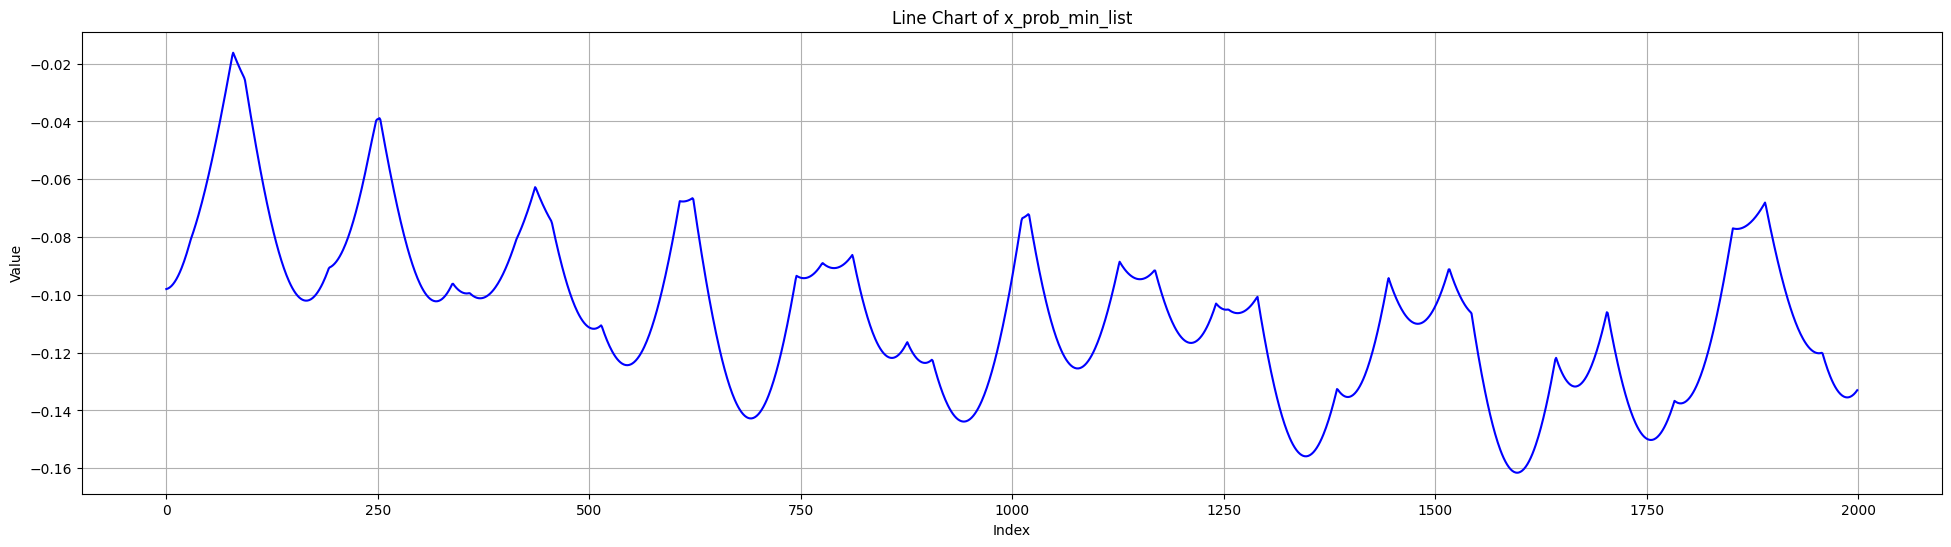

-0.013800369336914893


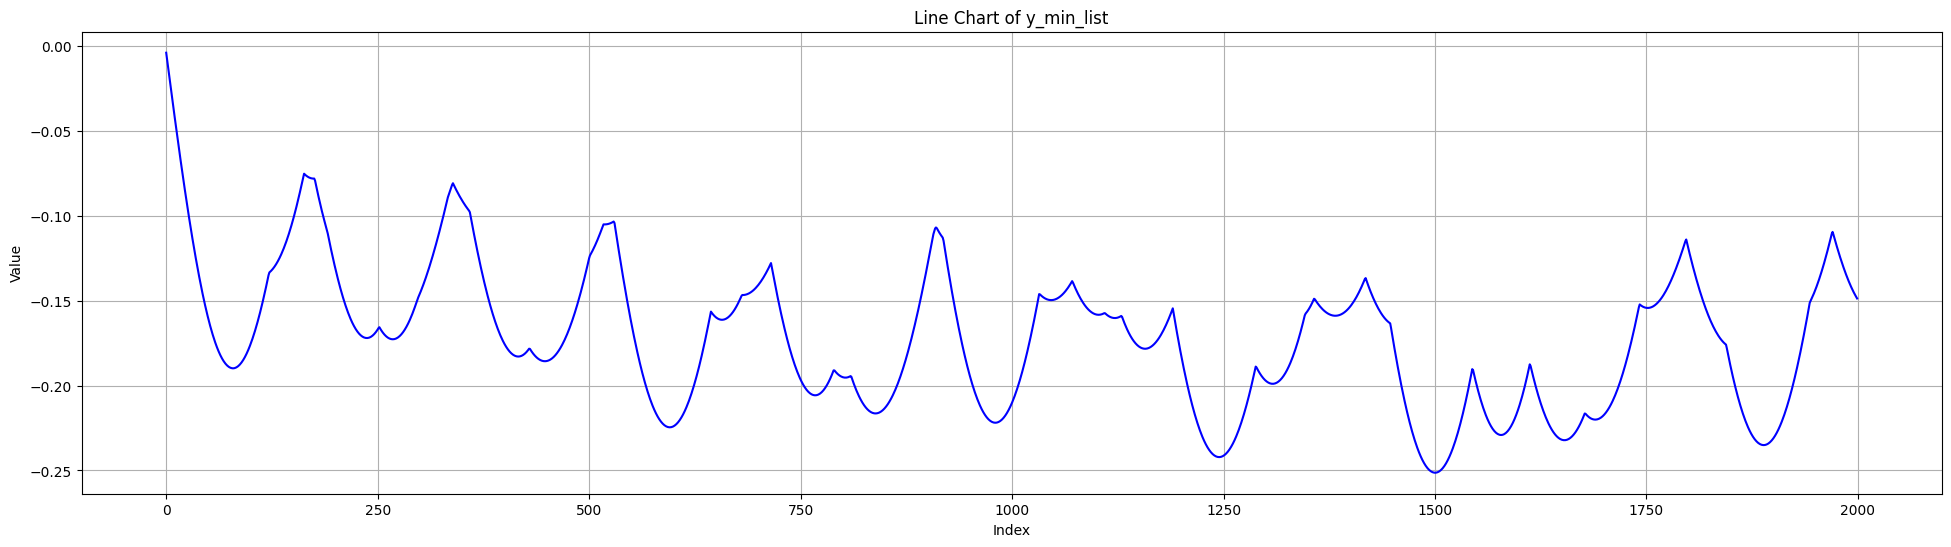

-0.013800369336914893


In [1]:
import numpy as np

gradient_list = []
one_hot_grad_list = []
coloring_grad_list = []
x_max_list = []
x_prob_max_list = []
y_max_list = []
x_min_list = []
x_prob_min_list = []
y_min_list = []

adj_matrix = np.array([[0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [0, 0, 1, 1, 1, 1, 1, 1, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 0, 1, 0]])

num_colors = 7
steps=2000
a0=1.0
c0=1
dt=0.01

# Get problem size
N = adj_matrix.shape[0]  # Number of vertices
K = num_colors  # Number of colors

# Initialize positions and momenta
# Instead of N binary variables, we now have N×K variables (one for each vertex-color pair)
x = np.random.uniform(-0.1, 0.1, (N, K))  # Position variables
y = np.zeros((N, K))                      # Momentum variables

# Initialize history arrays
x_history = np.zeros((steps + 1, N, K))
x_history[0] = x.copy()

# Define a(t) function - linear increase from 0 to a0
def a_t_func(t):
    return min(a0 * t / (0.2 * steps * dt), a0)

# Main simulation loop
for step in range(1, steps + 1):
    t = step * dt
    a_t = a_t_func(t)
    
    # Get current approximate binary state using sigmoid
    # x_prob = 1 / (1 + np.exp(-x))  # Values between 0 and 1
    # x_prob = (x +1)/2
    x_prob = x
    
    # Calculate the gradient of the energy function
    gradient = np.zeros((N, K))
    
    # 1. Graph coloring constraint: adjacent vertices should have different colors
    for i in range(N):
        for j in range(N):
            if adj_matrix[i, j] == 1:  # If vertices i and j are adjacent
                for c in range(K):
                    # If j has color c, push i away from color c
                    coloring_grad = c0 * x_prob[j, c]
                    gradient[i, c] += 0.5*coloring_grad
    
    # 2. One-hot encoding constraint: each vertex should have exactly one color
    for i in range(N):
        color_sum = np.sum(x_prob[i])
        for c in range(K):
            # Penalize if sum != 1
            one_hot_grad = c0 * (color_sum - 1 + K) * x_prob[i, c]
            gradient[i, c] += 0.5* one_hot_grad
    
    # First part of symplectic Euler: update momenta
    # ẏ = -[a0 - a(t)]x - gradient
    y -= dt * ((a0 - a_t) * x + gradient)
    
    # Second part: update positions
    # ẋ = a0 * y
    x += dt * a0 * y

    print('#####################################################')
    print(f'iteration {step} begins')

    print(f'max value of x {x.max()}, min value of x {x.min()}')
    print(f'max value of x_prob {x_prob.max()}, min value of x_prob {x_prob.min()}')
    print(f'max value of y {y.max()}, min value of y {y.min()}')
    

    # # Apply inelastic walls to help converge to binary solutions
    # for i in range(N):
    #     # Find the maximum value for this vertex
    #     max_idx = np.argmax(x[i])
    #     max_val = x[i, max_idx]
        
    #     # If max is above threshold, make the solution more "binary"
    #     if abs(max_val) > 3.0:
    #         # Reset all components
    #         y[i] = np.zeros(K)
    #         x[i] = np.ones(K) * -2.0  # All start negative
    #         x[i, max_idx] = 2.0  # Except the max one'

    outside_range = np.abs(x) > 1
    if np.any(outside_range):
            # Replace with sign (±1)
            x[outside_range] = np.sign(x[outside_range])
            # Set corresponding momenta to 0
            y[outside_range] = 0.0

    print('###################### capping ###############################')
    print(f'max value of x after cap {x.max()}, min value of x after cap {x.min()}')
    print(f'max value of x_prob {x_prob.max()}, min value of x_prob {x_prob.min()}')
    print(f'max value of y after cap  {y.max()}, min value of y after cap  {y.min()}')

    x_max_list.append(x.max())
    x_prob_max_list.append(x_prob.max())
    y_max_list.append(y.max())
    x_min_list.append(x.min())
    x_prob_min_list.append(x_prob.min())
    y_min_list.append(y.min())
    
    # Store current positions
    x_history[step] = x.copy()
    gradient_sum = gradient.sum()
    gradient_list.append(gradient_sum)
    one_hot_grad_list.append(one_hot_grad.sum())
    coloring_grad_list.append(coloring_grad.sum())

    print(f'iteration {step} ends')
    print('#####################################################')
    

# Get final color assignment
# For each vertex, select the color with the highest value
color_assignment = np.argmax(x, axis=1) + 1  # +1 to make colors 1-indexed

# Count violations (adjacent vertices with the same color)
violation_count = 0
for i in range(N):
    for j in range(i+1, N):
        if adj_matrix[i, j] == 1 and color_assignment[i] == color_assignment[j]:
            violation_count += 1

import matplotlib.pyplot as plt

plt.figure(figsize=(24, 6))  # Set width to 24 and height to 6
plt.plot(gradient_list, linestyle='-', color='b')
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Line Chart of gradient_list")
plt.grid(True)
plt.show()
print(gradient_list[-1])


plt.figure(figsize=(24, 6))  # Set width to 24 and height to 6
plt.plot(one_hot_grad_list, linestyle='-', color='b')
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Line Chart of one_hot_grad_list")
plt.grid(True)
plt.show()
print(one_hot_grad_list[-1])

plt.figure(figsize=(24, 6))  # Set width to 24 and height to 6
plt.plot(coloring_grad_list, linestyle='-', color='b')
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Line Chart of coloring_grad_list")
plt.grid(True)
plt.show()
print(coloring_grad_list[-1])

plt.figure(figsize=(24, 6))  # Set width to 24 and height to 6
plt.plot(x_max_list, linestyle='-', color='b')
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Line Chart of x_max_list")
plt.grid(True)
plt.show()
print(coloring_grad_list[-1])

plt.figure(figsize=(24, 6))  # Set width to 24 and height to 6
plt.plot(x_prob_max_list, linestyle='-', color='b')
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Line Chart of x_prob_max_list")
plt.grid(True)
plt.show()
print(coloring_grad_list[-1])

plt.figure(figsize=(24, 6))  # Set width to 24 and height to 6
plt.plot(y_max_list, linestyle='-', color='b')
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Line Chart of y_max_list")
plt.grid(True)
plt.show()
print(coloring_grad_list[-1])

plt.figure(figsize=(24, 6))  # Set width to 24 and height to 6
plt.plot(x_min_list, linestyle='-', color='b')
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Line Chart of x_min_list")
plt.grid(True)
plt.show()
print(coloring_grad_list[-1])

plt.figure(figsize=(24, 6))  # Set width to 24 and height to 6
plt.plot(x_prob_min_list, linestyle='-', color='b')
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Line Chart of x_prob_min_list")
plt.grid(True)
plt.show()
print(coloring_grad_list[-1])

plt.figure(figsize=(24, 6))  # Set width to 24 and height to 6
plt.plot(y_min_list, linestyle='-', color='b')
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Line Chart of y_min_list")
plt.grid(True)
plt.show()
print(coloring_grad_list[-1])




# Greedy coloring for comparison

In [ ]:
import numpy as np
import networkx as nx

def greedy_coloring(num_colors, adjacency_matrix):
    """
    Colors a graph using the greedy algorithm with a limited number of colors.
    
    Parameters:
    -----------
    num_colors : int
        Maximum number of colors to use (0 to num_colors-1)
    adjacency_matrix : numpy.ndarray
        Adjacency matrix representation of the graph
    
    Returns:
    --------
    tuple
        (node_colors, violations)
        - node_colors: Dictionary mapping node index to color
        - violations: Number of edges where both endpoints have the same color
    """
    # Convert adjacency matrix to NetworkX graph
    G = nx.from_numpy_array(adjacency_matrix)
    
    # Initialize colors dictionary
    node_colors = {}
    
    # Process nodes in order (can be customized with different node orderings)
    for node in G.nodes():
        # Get colors of neighbors
        neighbor_colors = set()
        for neighbor in G.neighbors(node):
            if neighbor in node_colors:
                neighbor_colors.add(node_colors[neighbor])
        
        # Find the smallest available color
        color = 0
        while color in neighbor_colors and color < num_colors:
            color += 1
            
        # If we've exceeded available colors, use the last available color
        if color >= num_colors:
            color = num_colors - 1
            
        # Assign the color
        node_colors[node] = color
    
    # Count violations (edges where both endpoints have the same color)
    violations = 0
    for u, v in G.edges():
        if node_colors[u] == node_colors[v]:
            violations += 1
    
    return node_colors, violations

colors, violations = greedy_coloring(num_colors, adj_matrix)

print("Node colors:", colors)
print("Number of violations:", violations)

# Visualize the coloring (optional)
import matplotlib.pyplot as plt

G = nx.from_numpy_array(adj_matrix)
color_map = [colors[node] for node in G.nodes()]

plt.figure(figsize=(8, 6))
nx.draw(G, node_color=color_map, with_labels=True, 
        cmap=plt.cm.rainbow, node_size=800)
plt.title(f"Graph Coloring with {len(set(color_map))} colors, {violations} violations")
plt.show()